<a href="https://colab.research.google.com/github/Scott-Huston/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

age                (17.938, 38.667]      ...       (59.333, 80.0]
exercise_time          (-0.3, 75.0]      ...       (225.0, 300.0]
weight                                   ...                     
(99.854, 124.333]                19      ...                    3
(124.333, 148.667]               17      ...                    6
(148.667, 173.0]                 14      ...                    6
(173.0, 197.333]                 21      ...                    0
(197.333, 221.667]               26      ...                    0
(221.667, 246.0]                  9      ...                    0

[6 rows x 12 columns]

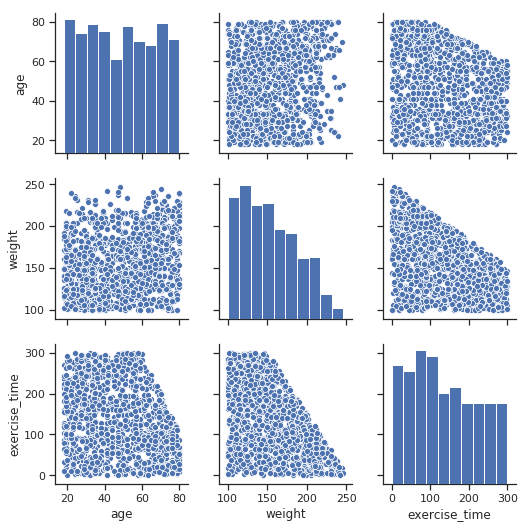

In [29]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# Importing libraries
import seaborn as sns
!pip install pandas==0.23.4
import pandas as pd

# Reading csv
df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col = 0)


# Getting initial feel for the data
df.head()

sns.set(style = "ticks", color_codes = True)
g = sns.pairplot(df)

# I want to investigate the effect of exercise_time on weight with age as a possible cofounder

# Binning the data for all of the variables
age_bins = pd.cut(df['age'],3)
weight_bins = pd.cut(df['weight'],6)
exercise_time_bins = pd.cut(df['exercise_time'],4)

# Displaying initial crosstab. This is the right data but very hard to scan and interpret
pd.crosstab(weight_bins, [age_bins, exercise_time_bins])


age                (17.938, 38.667]      ...       (59.333, 80.0]
exercise_time          (-0.3, 75.0]      ...       (225.0, 300.0]
weight                                   ...                     
(99.854, 124.333]                19      ...                    3
(124.333, 148.667]               17      ...                    6
(148.667, 173.0]                 14      ...                    6
(173.0, 197.333]                 21      ...                    0
(197.333, 221.667]               26      ...                    0
(221.667, 246.0]                  9      ...                    0

[6 rows x 12 columns]

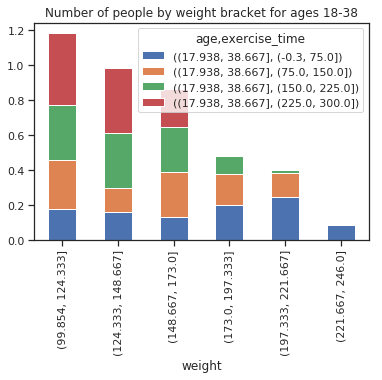

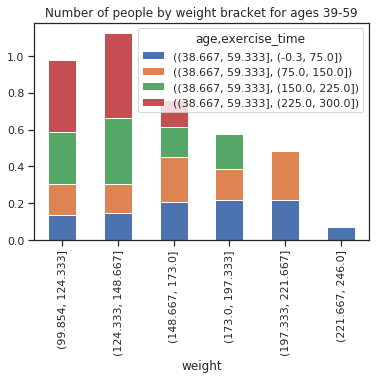

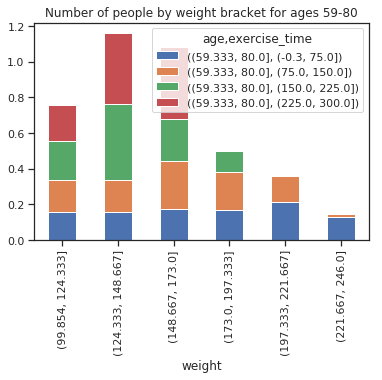

In [28]:
# putting crosstab table in a df and normalizing the data
binned_data = pd.crosstab(weight_bins, [age_bins, exercise_time_bins], normalize = 'columns')

# Creating seperate data for each age range
binned_data_age1 = binned_data.iloc[:, [0,1,2,3]]
binned_data_age2 = binned_data.iloc[:, [4,5,6,7]]
binned_data_age3 = binned_data.iloc[:, [8,9,10,11]]

# Graphing each age range 
binned_data_age1.plot(kind = 'bar', stacked = True, title = 'Number of people by weight bracket for ages 18-38');
binned_data_age2.plot(kind = 'bar', stacked = True, title = 'Number of people by weight bracket for ages 39-59');
binned_data_age3.plot(kind = 'bar', stacked = True, title = 'Number of people by weight bracket for ages 59-80');

pd.crosstab(weight_bins, [age_bins, exercise_time_bins])


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
All of the variables are discrete and ordinal (though all of the variables have small, 1 unit discrete steps, so they could be thought of as continuous).

2.  What are the relationships between the variables?

Above age 60, greater age is associated with less exercise time.
Greater amounts of exercise time are associated with lower weight.
Greater age looks weakly associated with higher weight.

3.  Which relationships are "real", and which spurious?

Excercise time has a similar negative impact on weight in all of the age ranges I looked at so that appears to be a real relationship that is not simply an artifact of age effects.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)